In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from collections import Iterable
import random
from os import listdir
from os.path import isfile, join

import scipy.stats as st

import seaborn as sns
sns.set_style("whitegrid")

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

D:\Users\glede\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


# Calculations for stats and plots are based on: https://github.com/stasmix/popsynth/blob/master/pop-synth-vae.ipynb

# Load the files

In [3]:
dataset = 'Chicago'

In [4]:
synth_dir = '../synth_data/' + dataset

files = ['../data/' + dataset + '/data.csv']
labels = ['original']

for f in listdir(synth_dir):
    if isfile(join(synth_dir, f)):
        files.append(join(synth_dir, f))
        labels.append(f.split('.')[0])

In [5]:
labels

['original',
 'CTGAN',
 'DATGAN',
 'DATGAN2',
 'DATGAN3',
 'DATGAN4',
 'DATGAN_cpl',
 'DATGAN_PRELSTM',
 'DATGAN_PRELSTM2',
 'TGAN',
 'TGAN2']

In [6]:
dfs = [pd.read_csv(file) for file in files]

In [7]:
if dataset is 'Chicago':
    continuous_cols = ['distance', 'age', 'departure_time']
elif dataset is 'LPMC':
    continuous_cols = ['start_time_linear', 'age', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'driving_traffic_percent']

In [8]:
dfs[0]

,choice,travel_dow,trip_purpose,distance,hh_vehicles,hh_size,hh_bikes,hh_descr,hh_income,gender,age,license,education_level,work_status,departure_time
0,drive,7,HOME_OTHER,23.42579,2,2,0,2,6,1,66,1.0,6,FTE,9.333333
1,drive,7,OTHER,1.71259,2,2,0,2,6,1,66,1.0,6,FTE,12.083333
2,drive,7,HOME_OTHER,21.77887,2,2,0,2,6,1,66,1.0,6,FTE,15.500000
3,drive,7,SHOPPING,2.02603,2,2,0,2,6,1,66,1.0,6,FTE,17.500000
4,drive,7,SHOPPING,0.87691,2,2,0,2,6,1,66,1.0,6,FTE,18.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87941,drive,2,OTHER,2.42141,1,1,0,1,3,0,59,1.0,4,PTE,13.750000
87942,drive,2,HOME_OTHER,1.16283,1,1,0,1,3,0,59,1.0,4,PTE,14.083333
87943,drive,2,HOME_OTHER,0.54234,1,1,0,1,3,0,59,1.0,4,PTE,14.666667
87944,drive,2,OTHER,1.49183,1,1,0,1,3,0,59,1.0,4,PTE,15.333333


# Transform all values in numerical

In [9]:
dfs[0].dtypes

choice              object
travel_dow           int64
trip_purpose        object
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status         object
departure_time     float64
dtype: object

In [10]:
if dataset is 'Chicago':
    ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'education_level', 'age']
    floats = ['departure_time', 'distance', 'license']
    strs = ['choice', 'trip_purpose', 'work_status']
elif dataset is 'LPMC':
    ints = ['survey_year', 'travel_year', 'travel_month', 'travel_date', 'day_of_week', 'age', 'female', 'driving_license', 'car_ownership', 'distance', 'pt_n_interchanges']
    floats = ['bus_scale', 'start_time_linear', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'cost_driving_con_charge', 'driving_traffic_percent']
    strs = ['travel_mode', 'purpose', 'fueltype', 'faretype']

In [11]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [12]:
dfs = [df.astype(dct) for df in dfs]

In [13]:
for c in strs: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [14]:
dfs[0].dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
departure_time     float64
dtype: object

# Compute the stats

In [15]:
# calculate min_max_bins for an arbitrary discretization scheme
def get_min_max(data1, data2, num_bins, cont_cols):
    """
    Create a dictionnary with all variables indicating the number of bins and the min and max value 
    """
    
    min_max = {}
    eps = 1e-10
    
    # Go through all columns in the first dataset (assuming data2 has the same columns)
    for c in data1.columns:
        if c in cont_cols: # Continuous column
            
            # Compute min and max values between both datasets
            min_val = min(np.min(data1[c]), np.min(data2[c])) - eps
            max_val = max(np.max(data1[c]), np.max(data2[c])) + eps
            
            # Fill the dict
            min_max[c] = [min_val, max_val, num_bins]
            
        else: # Categorical column
            # Set of all unique values in both datasets
            unique_vals = set(np.unique(data1[c])).union(set(np.unique(data2[c])))
                                    
            num_bins_cat = min(len(unique_vals), num_bins)
            
            min_max[c] = [min(unique_vals), max(unique_vals), num_bins_cat]
                

    return min_max

In [16]:
def get_frequency_list(original, synthetic, max_num_bins, cat=True):
    """
    Compute the frequency lists
    """
    
    # Check if the number of unique values is less than the max
    # number of bins for the cat variables
    if cat:
        unique_vals = set(np.unique(original)).union(set(np.unique(synthetic)))
        
        if len(unique_vals) > max_num_bins:
            cat = False
    
    eps = 1e-10
    # Compute min and max values between both datasets
    min_val = min(np.min(original), np.min(synthetic)) - eps
    max_val = max(np.max(original), np.max(synthetic)) + eps
    
    # Compute the bins
    bins = []
    if cat:
        # bins = all values
        bins = list(unique_vals)
        bins.sort()
    else:
        # bins = hist bins
        delta = (max_val-min_val)/max_num_bins
        for i in range(max_num_bins+1):
            bins.append(min_val+delta*i)
            
    # Calculate the frequencies
    freqs = []
    if cat:
        count_orig = [(original==b).sum() for b in bins]
        count_synth = [(synthetic==b).sum() for b in bins]
        
        freqs = [count_orig, count_synth]
    else:
        hist_orig, _ = np.histogram(original, bins)
        hist_synth, _ = np.histogram(synthetic, bins)
        
        freqs = [hist_orig, hist_synth]

            
    return freqs, bins

In [17]:
def stats(freq_list_orig, freq_list_synth):
    """
    Different statistics computed on the frequency list
    
    """
    freq_list_orig, freq_list_synth = np.array(freq_list_orig), np.array(freq_list_synth)
    corr_mat = np.corrcoef(freq_list_orig, freq_list_synth)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(freq_list_orig - freq_list_synth).mean()
    # RMSE
    rmse = np.linalg.norm(freq_list_orig - freq_list_synth) / np.sqrt(len(freq_list_orig))
    # SRMSE
    freq_list_orig_avg = freq_list_orig.mean()
    srmse = rmse / freq_list_orig_avg
    # r-square
    u = np.sum((freq_list_synth - freq_list_orig)**2)
    v = np.sum((freq_list_orig - freq_list_orig_avg)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    
    return stat

In [18]:
def plot(freqs_original, freqs_synthetic, title=None, filename=None):
    f = plt.figure(figsize=(10,10))
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

    matplotlib.rc('font', **font)
    ax = f.add_subplot(111)
    
    min_val = min(np.min(freqs_original), np.min(freqs_synthetic))
    max_val = max(np.max(freqs_original), np.max(freqs_synthetic))
    
    plt.plot(freqs_original, freqs_synthetic, 'ok')
    
    reg = LinearRegression()
    reg.fit(np.array(freqs_original)[:, np.newaxis], np.array(freqs_synthetic))
    
    xfit = np.linspace(np.min(freqs_original), np.max(freqs_original), 10)
    yfit = reg.predict(xfit[:, np.newaxis])
    
    plt.plot(xfit, yfit, 'grey')
    
    stat = stats(freqs_original, freqs_synthetic)
    
    str_ = "SRMSE={:.3f}\nR²={:.3f}\ny={:.3f}x".format(stat['srmse'], stat['r2'], reg.coef_[0])
    
    t = plt.text(0.05, 0.9,str_,
                 horizontalalignment='left',
                 verticalalignment='center',
                 transform = ax.transAxes,
                 fontsize=18)
    
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.xlabel('Observed frequencies')
    plt.ylabel('Simulated frequencies')
    plt.xlim((0,8000))
    plt.ylim((0,8000))
    
    if title is not None:
        plt.title(title)
        
    if filename is not None:
        plt.savefig(filename + '.png', bbox_inches='tight')
        plt.savefig(filename + '.pdf', bbox_inches='tight')

# Let's have some fun =)

In [19]:
orig_freqs = []
synth_freqs = []

for i in range(len(dfs)-1):
    synth_freqs.append([])

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50, c not in continuous_cols)
        
        if i == 1:
            orig_freqs.append(a)
        
        synth_freqs[i-1].append(b)

In [20]:
def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [21]:
orig_freqs = list(flatten(orig_freqs))


for i in range(len(synth_freqs)):
    synth_freqs[i] = list(flatten(synth_freqs[i]))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


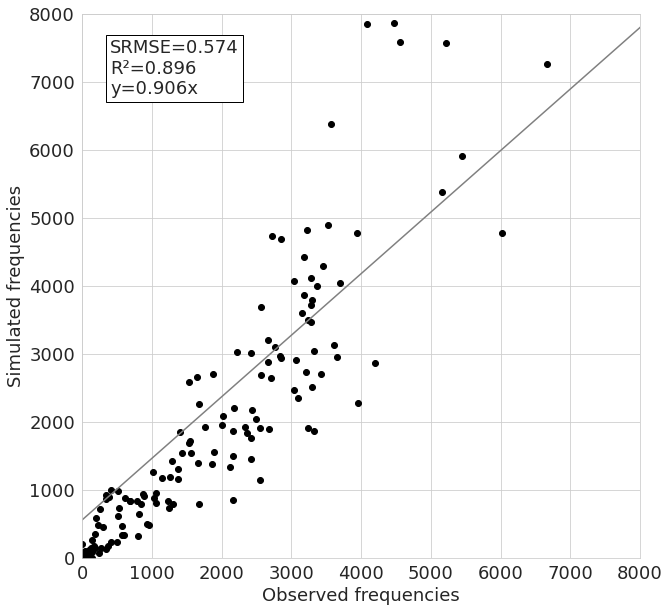

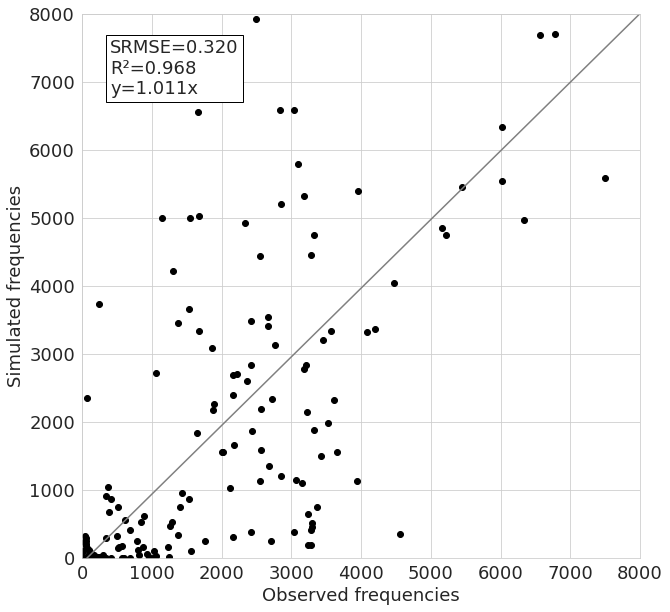

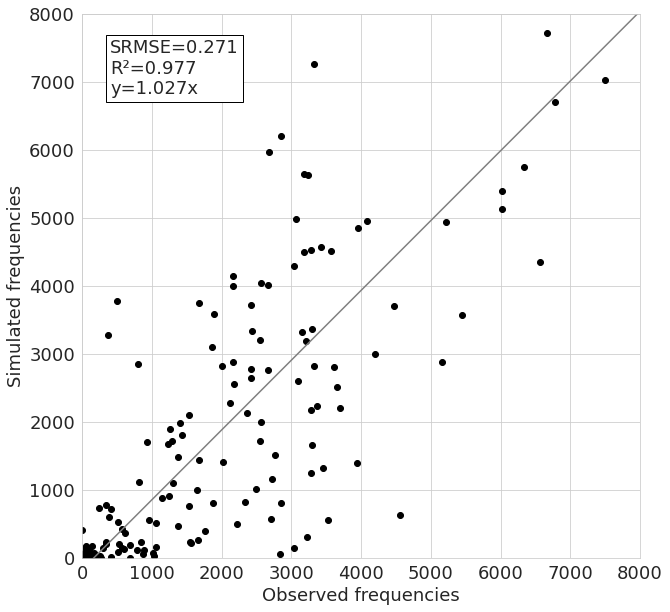

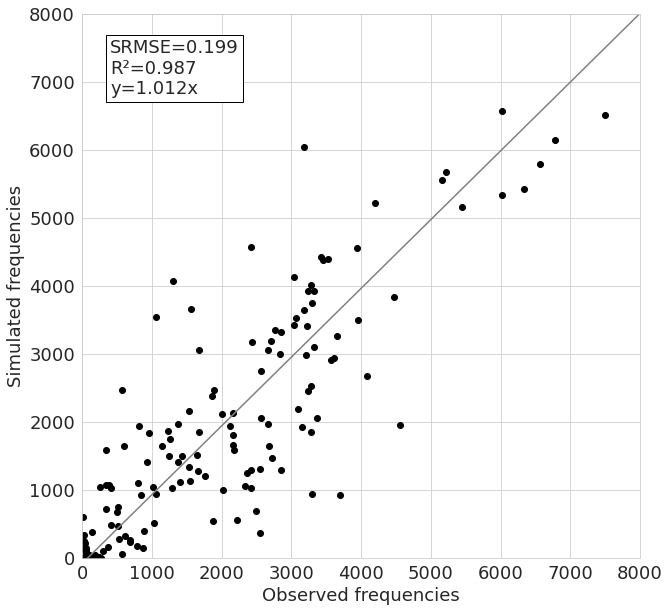

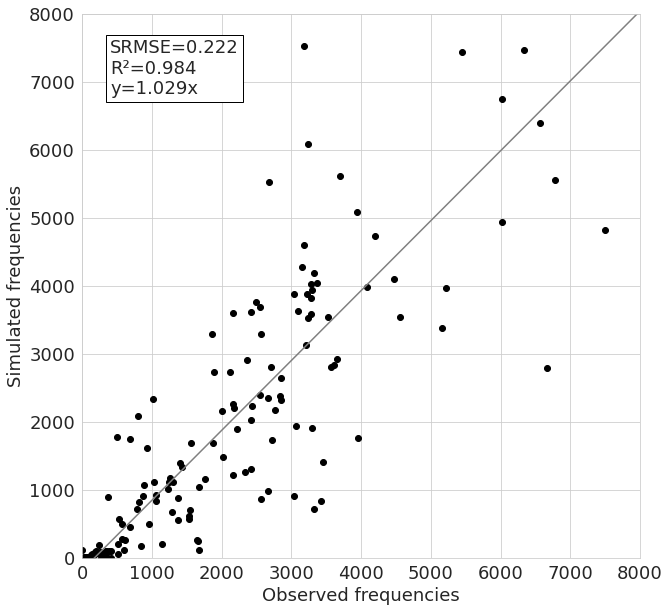

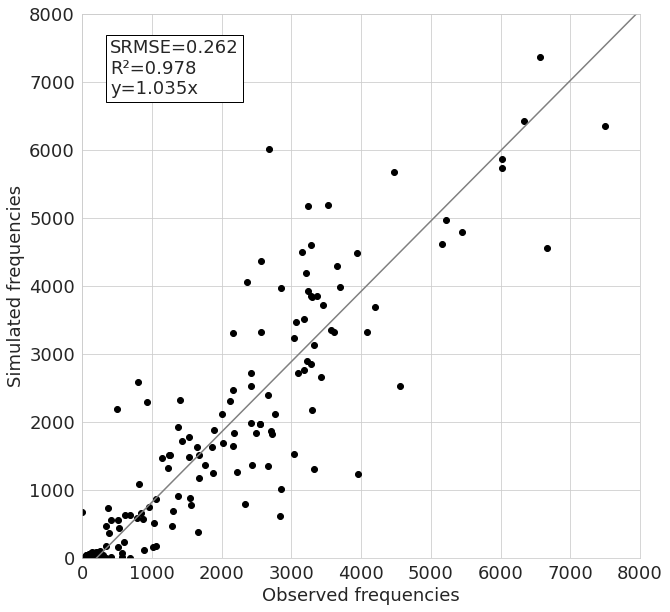

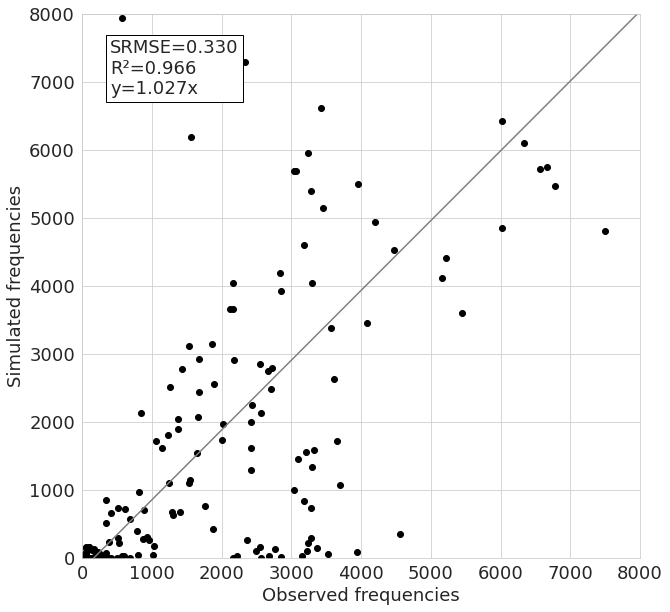

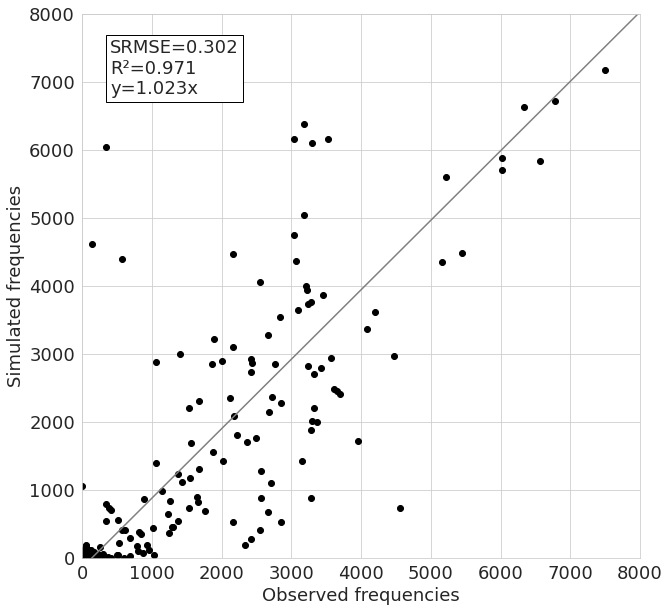

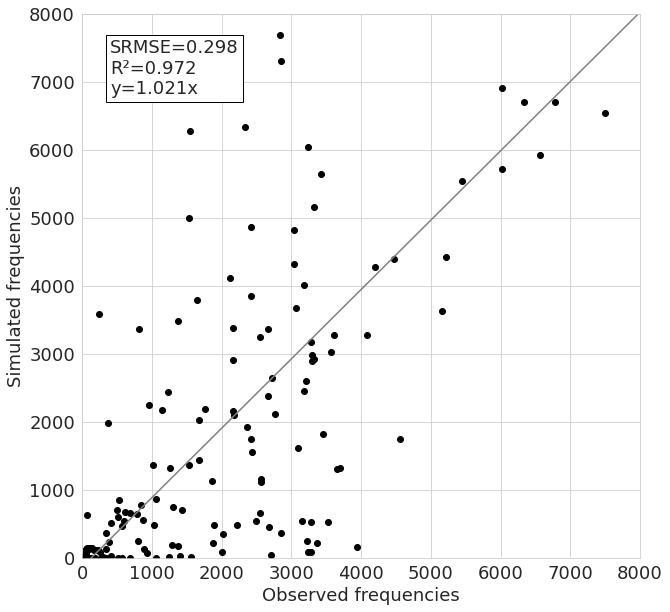

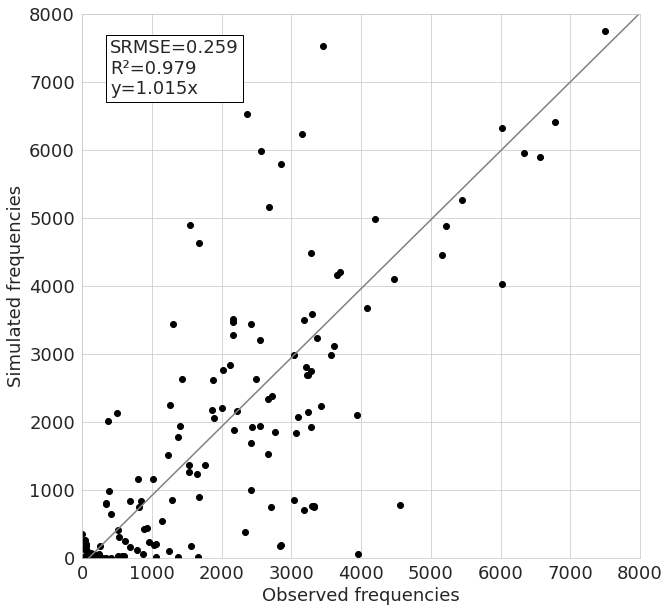

In [22]:
for i in range(len(synth_freqs)):  
    #plot(orig_freqs, synth_freqs[i], labels[0] + ' - ' + labels[i+1])
    plot(orig_freqs, synth_freqs[i], None, '../figures/' + dataset + '/' + labels[i+1])

# Stats by model

In [23]:
stats_vals = []

for i in range(len(dfs)-1):
    stats_vals.append({'mae': [], 'rmse': [], 'r2': [], 'srmse': [], 'corr': []})

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50)
        
        stat = stats(a,b)
        
        for k in stat.keys():
            stats_vals[i-1][k].append(stat[k])
            
n = len(stats_vals)

In [24]:
print("Weighted average of SRMSE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['srmse']), np.std(stats_vals[i]['srmse'])))

Weighted average of SRMSE
CTGAN: 0.374 +- 0.156
DATGAN: 0.321 +- 0.548
DATGAN2: 0.233 +- 0.311
DATGAN3: 0.176 +- 0.219
DATGAN4: 0.198 +- 0.237
DATGAN_cpl: 0.198 +- 0.287
DATGAN_PRELSTM: 0.299 +- 0.446
DATGAN_PRELSTM2: 0.271 +- 0.386
TGAN: 0.258 +- 0.413
TGAN2: 0.230 +- 0.341


In [25]:
print("Weighted average of RMSE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['rmse']), np.std(stats_vals[i]['rmse'])))

Weighted average of RMSE
CTGAN: 4914.212 +- 3532.110
DATGAN: 1311.430 +- 815.529
DATGAN2: 1268.738 +- 464.857
DATGAN3: 1040.846 +- 478.572
DATGAN4: 1212.302 +- 306.792
DATGAN_cpl: 1301.502 +- 994.378
DATGAN_PRELSTM: 1430.145 +- 622.953
DATGAN_PRELSTM2: 1486.881 +- 734.740
TGAN: 1163.038 +- 702.252
TGAN2: 1159.773 +- 554.242


In [26]:
print("Weighted average of MAE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['mae']), np.std(stats_vals[i]['mae'])))

Weighted average of MAE
CTGAN: 4082.633 +- 3487.274
DATGAN: 984.361 +- 518.197
DATGAN2: 991.697 +- 381.469
DATGAN3: 836.709 +- 415.265
DATGAN4: 945.943 +- 356.597
DATGAN_cpl: 1021.688 +- 882.393
DATGAN_PRELSTM: 1063.146 +- 474.711
DATGAN_PRELSTM2: 1108.553 +- 567.937
TGAN: 900.184 +- 603.677
TGAN2: 858.013 +- 366.884


In [27]:
print("Weighted average of R^2")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['r2']), np.std(stats_vals[i]['r2'])))

Weighted average of R^2
CTGAN: -0.420 +- 3.887
DATGAN: 0.632 +- 0.812
DATGAN2: 0.809 +- 0.483
DATGAN3: 0.903 +- 0.187
DATGAN4: 0.845 +- 0.320
DATGAN_cpl: 0.906 +- 0.174
DATGAN_PRELSTM: 0.521 +- 1.266
DATGAN_PRELSTM2: 0.783 +- 0.548
TGAN: 0.597 +- 1.015
TGAN2: 0.786 +- 0.571


In [28]:
print("Weighted average of corr")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['corr']), np.std(stats_vals[i]['corr'])))

Weighted average of corr
CTGAN: 0.884 +- 0.137
DATGAN: 0.917 +- 0.169
DATGAN2: 0.951 +- 0.117
DATGAN3: 0.964 +- 0.077
DATGAN4: 0.959 +- 0.088
DATGAN_cpl: 0.973 +- 0.055
DATGAN_PRELSTM: 0.912 +- 0.213
DATGAN_PRELSTM2: 0.939 +- 0.142
TGAN: 0.920 +- 0.192
TGAN2: 0.954 +- 0.101


# Continuous vs Categorical

In [29]:
msk = []
for i in dfs[0].columns:
    if i in continuous_cols:
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)

In [30]:
print("Weighted average of SRMSE (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['srmse'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['srmse'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['srmse'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['srmse'])[~msk])))

Weighted average of SRMSE (continuous / categorical)
CTGAN: 0.398 +- 0.096 / 0.369 +- 0.167
DATGAN: 1.339 +- 0.448 / 0.066 +- 0.027
DATGAN2: 0.819 +- 0.210 / 0.086 +- 0.047
DATGAN3: 0.596 +- 0.107 / 0.070 +- 0.044
DATGAN4: 0.667 +- 0.044 / 0.081 +- 0.033
DATGAN_cpl: 0.669 +- 0.355 / 0.081 +- 0.046
DATGAN_PRELSTM: 1.132 +- 0.347 / 0.091 +- 0.049
DATGAN_PRELSTM2: 0.975 +- 0.340 / 0.094 +- 0.050
TGAN: 1.050 +- 0.258 / 0.060 +- 0.029
TGAN2: 0.836 +- 0.336 / 0.079 +- 0.052


In [31]:
print("Weighted average of RMSE (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['rmse'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['rmse'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['rmse'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['rmse'])[~msk])))

Weighted average of RMSE (continuous / categorical)
CTGAN: 699.378 +- 169.727 / 5967.920 +- 3167.972
DATGAN: 2354.467 +- 787.553 / 1050.671 +- 579.932
DATGAN2: 1440.338 +- 369.654 / 1225.837 +- 476.184
DATGAN3: 1048.223 +- 188.408 / 1039.002 +- 526.686
DATGAN4: 1173.607 +- 77.116 / 1221.976 +- 340.142
DATGAN_cpl: 1176.911 +- 623.667 / 1332.650 +- 1064.845
DATGAN_PRELSTM: 1990.870 +- 610.611 / 1289.964 +- 541.870
DATGAN_PRELSTM2: 1714.370 +- 597.214 / 1430.009 +- 754.629
TGAN: 1846.912 +- 454.109 / 992.069 +- 647.104
TGAN2: 1471.319 +- 590.237 / 1081.886 +- 516.289


In [32]:
print("Weighted average of MAE (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['mae'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['mae'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['mae'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['mae'])[~msk])))

Weighted average of MAE (continuous / categorical)
CTGAN: 410.573 +- 38.113 / 5000.648 +- 3314.699
DATGAN: 1278.893 +- 32.796 / 910.729 +- 555.232
DATGAN2: 908.053 +- 282.978 / 1012.607 +- 399.616
DATGAN3: 668.947 +- 19.635 / 878.650 +- 454.604
DATGAN4: 683.867 +- 157.620 / 1011.462 +- 362.322
DATGAN_cpl: 570.600 +- 194.254 / 1134.460 +- 948.815
DATGAN_PRELSTM: 1221.453 +- 534.498 / 1023.569 +- 449.927
DATGAN_PRELSTM2: 968.520 +- 301.773 / 1143.561 +- 611.798
TGAN: 1151.800 +- 488.258 / 837.280 +- 613.309
TGAN2: 917.720 +- 382.917 / 843.086 +- 361.227


In [33]:
print("Weighted average of R^2 (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['r2'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['r2'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['r2'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['r2'])[~msk])))

Weighted average of R^2 (continuous / categorical)
CTGAN: 0.832 +- 0.095 / -0.733 +- 4.289
DATGAN: -0.720 +- 0.997 / 0.970 +- 0.064
DATGAN2: 0.123 +- 0.758 / 0.981 +- 0.020
DATGAN3: 0.604 +- 0.238 / 0.978 +- 0.038
DATGAN4: 0.353 +- 0.447 / 0.968 +- 0.050
DATGAN_cpl: 0.652 +- 0.251 / 0.969 +- 0.045
DATGAN_PRELSTM: -1.294 +- 1.973 / 0.975 +- 0.026
DATGAN_PRELSTM2: -0.002 +- 0.856 / 0.979 +- 0.014
TGAN: -0.938 +- 1.482 / 0.981 +- 0.034
TGAN2: 0.068 +- 0.986 / 0.965 +- 0.056


In [34]:
print("Weighted average of Pearson's corr (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['corr'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['corr'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['corr'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['corr'])[~msk])))

Weighted average of Pearson's corr (continuous / categorical)
CTGAN: 0.933 +- 0.035 / 0.871 +- 0.150
DATGAN: 0.597 +- 0.122 / 0.997 +- 0.005
DATGAN2: 0.769 +- 0.166 / 0.996 +- 0.003
DATGAN3: 0.835 +- 0.094 / 0.996 +- 0.004
DATGAN4: 0.820 +- 0.118 / 0.994 +- 0.008
DATGAN_cpl: 0.896 +- 0.080 / 0.992 +- 0.018
DATGAN_PRELSTM: 0.585 +- 0.305 / 0.994 +- 0.009
DATGAN_PRELSTM2: 0.717 +- 0.199 / 0.995 +- 0.005
TGAN: 0.609 +- 0.253 / 0.998 +- 0.002
TGAN2: 0.801 +- 0.143 / 0.992 +- 0.021
